# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.ml as M

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white', font_scale=1.5, palette='pastel')
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('sparkify').getOrCreate()
spark

22/08/03 20:45:27 WARN Utils: Your hostname, localhost resolves to a loopback address: 127.0.0.1; using 192.168.3.149 instead (on interface en0)
22/08/03 20:45:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/03 20:45:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('medium-sparkify-event-data.json')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

### check null values

In [6]:
df.select([F.count(F.when(F.isnull(c),c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0---------------
 artist        | 110828 
 auth          | 0      
 firstName     | 15700  
 gender        | 15700  
 itemInSession | 0      
 lastName      | 15700  
 length        | 110828 
 level         | 0      
 location      | 15700  
 method        | 0      
 page          | 0      
 registration  | 15700  
 sessionId     | 0      
 song          | 110828 
 status        | 0      
 ts            | 0      
 userAgent     | 15700  
 userId        | 0      



- Number of missing values in artist, length, and song columns are the same.
- Number of missing values in firstName, gender, lastName, location, registration, and userAgent columns are the same.

In [7]:
df.where(F.col('artist').isNull())\
    .select([F.count(F.when(F.isnull(c),c)).alias(c) for c in ['length','song']])\
    .show(vertical=True)

-RECORD 0--------
 length | 110828 
 song   | 110828 



So the missing values in artist, length, and song columns belong to same data logs.

In [8]:
df.where(F.col('artist').isNotNull()).select('page').distinct().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



So the information on artist, length, and song will be recorded only if a user hit "NextSong" button, which is reasonable, and I will keep all the rows with missing values in those three columns.

In [9]:
df.where(F.col('firstName').isNull())\
    .select([F.count(F.when(F.isnull(c),c)).alias(c) for c in ['gender','lastName','location','registration','userAgent']])\
    .show(vertical=True)

-RECORD 0-------------
 gender       | 15700 
 lastName     | 15700 
 location     | 15700 
 registration | 15700 
 userAgent    | 15700 



So the missing values of the above columns also belong to the same data logs

In [10]:
df.where(F.col('firstName').isNull()).select('page').distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|              Login|
|               Help|
|              Error|
|Submit Registration|
|           Register|
+-------------------+



It is clear that users were stuck at registration page, and fail to register. So I will delete all rows with missing values in those columns.

In [11]:
df = df.dropna(how='any', subset=['firstName'])

### convert time format from timestamp to datetime

In [12]:
time_func = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumns({'datetime': time_func('ts'), 'reg_datetime': time_func('registration')})
df.select('userId','ts','datetime','registration','reg_datetime').show(3)

+------+-------------+-------------------+-------------+-------------------+
|userId|           ts|           datetime| registration|       reg_datetime|
+------+-------------+-------------------+-------------+-------------------+
|   293|1538352011000|2018-10-01 08:00:11|1532063507000|2018-07-20 13:11:47|
|    98|1538352025000|2018-10-01 08:00:25|1538069638000|2018-09-28 01:33:58|
|   179|1538352118000|2018-10-01 08:01:58|1535953455000|2018-09-03 13:44:15|
+------+-------------+-------------------+-------------+-------------------+
only showing top 3 rows



In [13]:
# extract year, month, day of month, day of week, hour from datetime
df = df.withColumns({
    'year': F.year(F.col('datetime')),
    'reg_year': F.year(F.col('reg_datetime')),
    'month': F.month(F.col('datetime')),
    'reg_month': F.month(F.col('reg_datetime')),
    'week_of_year': F.weekofyear(F.col('datetime')),
    'reg_woy': F.weekofyear(F.col('reg_datetime')),
    'day_of_month': F.dayofmonth(F.col('datetime')),
    'reg_dom': F.dayofmonth(F.col('reg_datetime')),
    'day_of_week': F.dayofweek(F.col('datetime')),
    'reg_dow': F.dayofweek(F.col('reg_datetime')),
    'hour': F.hour(F.col('datetime')),
    'reg_hour': F.hour(F.col('reg_datetime')),
})

df.select('userId','datetime','year','month','week_of_year','day_of_month','day_of_week','hour').show(3)
df.select('userId','reg_datetime','reg_year','reg_month','reg_woy','reg_dom','reg_dow','reg_hour').show(3)

+------+-------------------+----+-----+------------+------------+-----------+----+
|userId|           datetime|year|month|week_of_year|day_of_month|day_of_week|hour|
+------+-------------------+----+-----+------------+------------+-----------+----+
|   293|2018-10-01 08:00:11|2018|   10|          40|           1|          2|   8|
|    98|2018-10-01 08:00:25|2018|   10|          40|           1|          2|   8|
|   179|2018-10-01 08:01:58|2018|   10|          40|           1|          2|   8|
+------+-------------------+----+-----+------------+------------+-----------+----+
only showing top 3 rows



+------+-------------------+--------+---------+-------+-------+-------+--------+
|userId|       reg_datetime|reg_year|reg_month|reg_woy|reg_dom|reg_dow|reg_hour|
+------+-------------------+--------+---------+-------+-------+-------+--------+
|   293|2018-07-20 13:11:47|    2018|        7|     29|     20|      6|      13|
|    98|2018-09-28 01:33:58|    2018|        9|     39|     28|      6|       1|
|   179|2018-09-03 13:44:15|    2018|        9|     36|      3|      2|      13|
+------+-------------------+--------+---------+-------+-------+-------+--------+
only showing top 3 rows



## DEFINE CHURN
I define churn using `Cancellation Confirmation` page event.

In [14]:
churn_user = df.filter(df['page']=='Cancellation Confirmation')\
    .select('userId').distinct()\
    .withColumn('label', F.lit(1))

nonchurn_user = df.filter(~df['userId'].isin(churn_user.select('userId').rdd.flatMap(lambda x: x).collect()))\
    .select('userId').distinct()\
    .withColumn('label', F.lit(0))

df_churn = churn_user.union(nonchurn_user)
df_churn.groupBy('label').agg(F.count('userId')).show()

df_churn.filter(df_churn['label']==1).count() / df_churn.count()

+-----+-------------+
|label|count(userId)|
+-----+-------------+
|    1|           99|
|    0|          349|
+-----+-------------+



0.22098214285714285

Only 22% of users have churned, so this is an unbalanced dataset.

In [15]:
# merge label to original df
df = df.join(df_churn, on=['userId'])

## EDA

In [16]:
df.count()

528005

In [17]:
df.columns

['userId',
 'artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'datetime',
 'reg_datetime',
 'year',
 'reg_year',
 'month',
 'reg_month',
 'week_of_year',
 'reg_woy',
 'day_of_month',
 'reg_dom',
 'day_of_week',
 'reg_dow',
 'hour',
 'reg_hour',
 'label']

### How many artists have users of two groups (churn vs nonchurn) listened respectively?

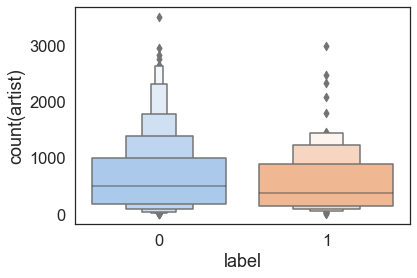

In [18]:
g = df.groupBy('label', 'userId').agg(F.count_distinct('artist')).toPandas()

sns.boxenplot(data=g, y='count(artist)', x='label');

Churned users listened slightly less number of artists than nonchurned users.

### How long the songs have users of two groups listened?

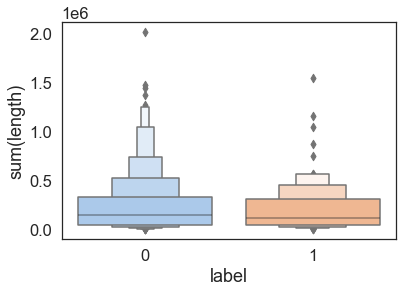

In [19]:
g = df.groupBy('label', 'userId').agg(F.sum('length')).toPandas()

sns.boxenplot(data=g, y='sum(length)', x='label');

Total length of songs nonchurned users have listened is slightly longer than churned users.

### Which gender is more likely to churn?

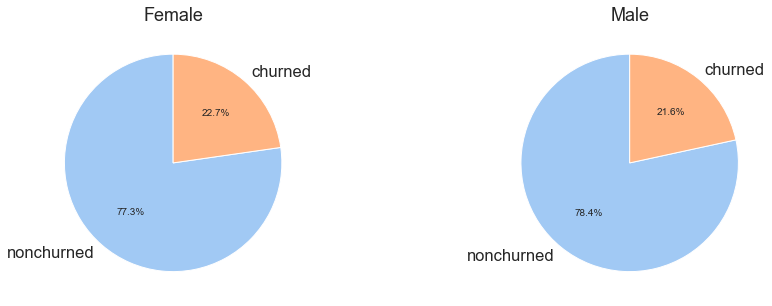

In [20]:
df_gender = df.select('label','userId','gender')\
    .dropDuplicates()\
    .groupBy('label','gender').count()\
    .orderBy('label')\
    .toPandas()

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].set_title('Female')
ax[1].set_title('Male')
ax[0].pie(df_gender[df_gender.gender=='F']['count'],labels=['nonchurned','churned'],startangle=90,autopct='%1.1f%%')
ax[1].pie(df_gender[df_gender.gender=='M']['count'],labels=['nonchurned','churned'],startangle=90,autopct='%1.1f%%');

Females are more likely to churn than males.

### How many items in each session do users in two groups have?

In [21]:
df.select('itemInSession').describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            528005|
|   mean|107.77899451709737|
| stddev|116.86478662970052|
|    min|                 0|
|    max|              1005|
+-------+------------------+



In [22]:
df.filter(df['userId']=='296').agg(F.count_distinct('itemInSession')).show()

+--------------------+
|count(itemInSession)|
+--------------------+
|                  82|
+--------------------+



In [23]:
df.filter(df['userId']=='296').agg(F.count_distinct('sessionId')).show()

+----------------+
|count(sessionId)|
+----------------+
|               5|
+----------------+



In [24]:
df.filter(df['userId']=='98').select('page','datetime','sessionId','itemInSession').show(100)

+---------------+-------------------+---------+-------------+
|           page|           datetime|sessionId|itemInSession|
+---------------+-------------------+---------+-------------+
|       NextSong|2018-10-01 08:00:25|       97|           74|
|       NextSong|2018-10-01 08:06:45|       97|           75|
|    Roll Advert|2018-10-01 08:07:15|       97|           76|
|       NextSong|2018-10-01 08:09:22|       97|           77|
|       NextSong|2018-10-01 08:12:36|       97|           78|
|           Help|2018-10-01 08:15:47|       97|           79|
|       NextSong|2018-10-02 14:51:24|      513|            0|
|       NextSong|2018-10-02 14:55:50|      513|            1|
|       NextSong|2018-10-02 15:00:03|      513|            2|
|       NextSong|2018-10-02 15:04:40|      513|            3|
|       NextSong|2018-10-02 15:07:11|      513|            4|
|       NextSong|2018-10-04 11:53:37|      623|            0|
|       NextSong|2018-10-04 11:57:50|      623|            1|
|Add to 

### What are the differences of length between users in 2 groups?

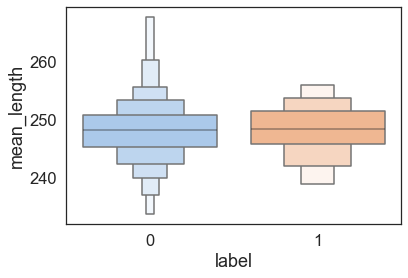

In [25]:
g = df.groupby('label','userId').agg(
    F.avg('length').alias('mean_length'),
    F.max('length').alias('max_length'),
    F.min('length').alias('min_length'),
    F.expr('percentile_approx(length, 0.5)').alias('median_length')
).toPandas()

sns.boxenplot(data=g, y='mean_length', x='label', showfliers=False);

mean length of songs listened by churned users are slightly longer than nonchurned users

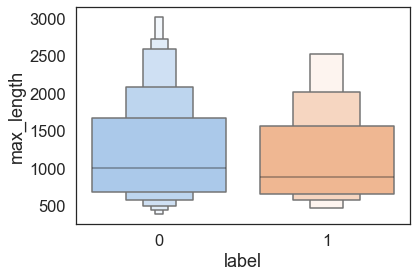

In [26]:
sns.boxenplot(data=g, y='max_length', x='label', showfliers=False);

max length of songs listened by churned users are slightly shorter than nonchurned users

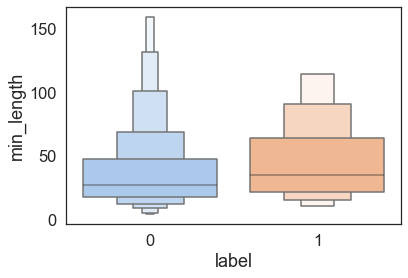

In [27]:
sns.boxenplot(data=g, y='min_length', x='label', showfliers=False);

min length of songs listened by churned users are slightly longer than nonchurned users

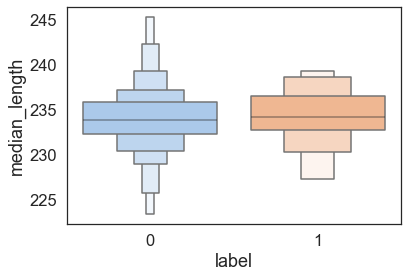

In [28]:
sns.boxenplot(data=g, y='median_length', x='label', showfliers=False);

median length of songs listened by churned users are slightly longer than nonchurned users, and distributions is narrower than nonchurned users.

### Which level of users are more likely to churn?

In [29]:
level_func = F.udf(lambda x: int(x=='paid'), T.IntegerType())
df_ = df.withColumn('is_paid', level_func('level'))\
    .groupBy('label','userId').agg(F.max('is_paid').alias('is_paid'))\
    .groupBy('label','is_paid').agg(F.count_distinct('userId').alias('num_users'))\
    .orderBy('label','is_paid')\
    .toPandas()

df_

,label,is_paid,num_users
0,0,0,103
1,0,1,246
2,1,0,24
3,1,1,75


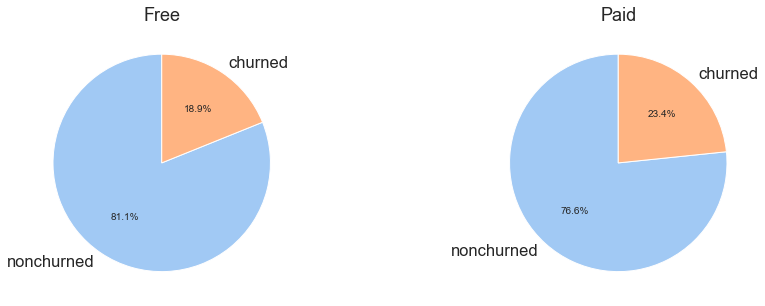

In [30]:
level_func = F.udf(lambda x: int(x=='paid'), T.IntegerType())
df_ = df.withColumn('is_paid', level_func('level'))\
    .groupBy('label','userId').agg(F.max('is_paid').alias('is_paid'))\
    .groupBy('label','is_paid').agg(F.count_distinct('userId').alias('num_users'))\
    .orderBy('label','is_paid')\
    .toPandas()

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].set_title('Free')
ax[1].set_title('Paid')
ax[0].pie(df_[df_.is_paid==0]['num_users'],labels=['nonchurned','churned'],startangle=90,autopct='%1.1f%%')
ax[1].pie(df_[df_.is_paid==1]['num_users'],labels=['nonchurned','churned'],startangle=90,autopct='%1.1f%%');

Free users are more likely to churn than paid users.

### Users of which states are more likely to churn?

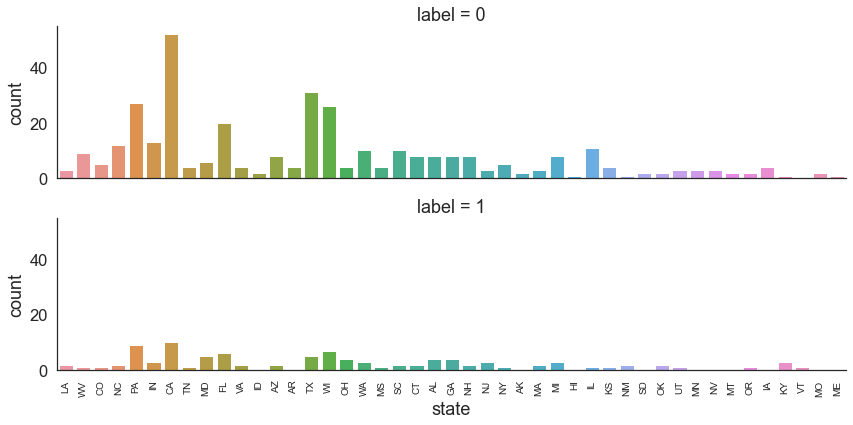

In [31]:
state_func = F.udf(lambda x: x[-2:])
df_ = df.withColumn('state', state_func('location'))\
    .select('label','state','userId')\
    .dropDuplicates()\
    .toPandas()

sns.catplot(data=df_, x='state', kind='count', row='label', aspect=4, height=3)
plt.xticks(rotation=90, fontsize=10);

Majority of nonchurned and churned users are in California, Texas, Penssylvania, and Wisconsin

### What are the difference of page events count between users of two groups?

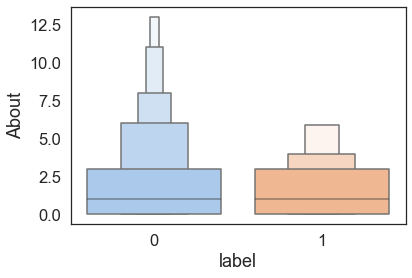

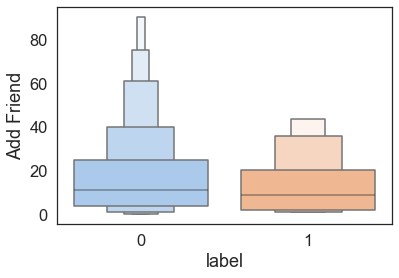

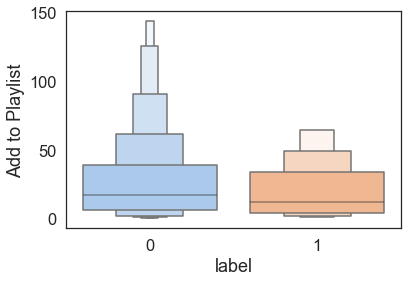

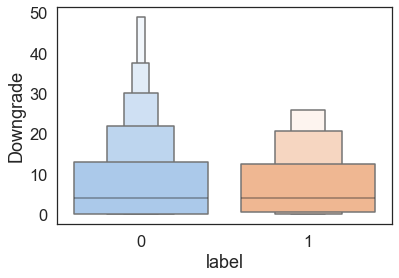

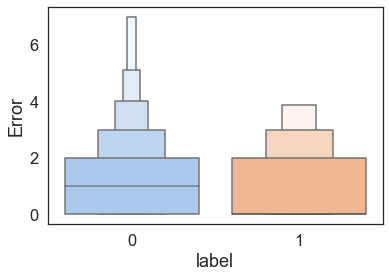

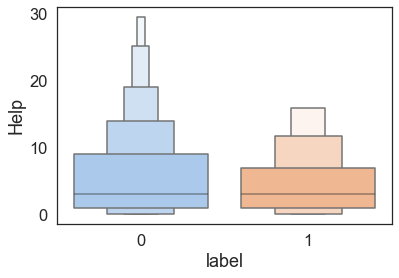

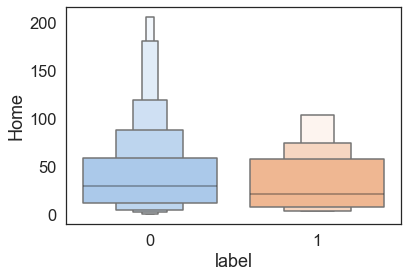

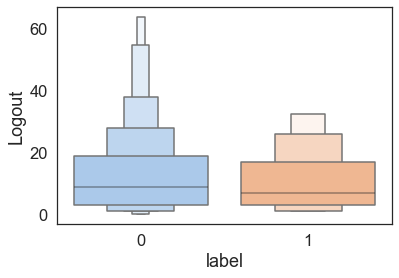

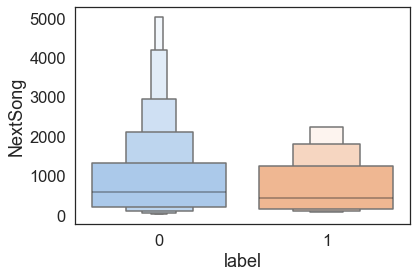

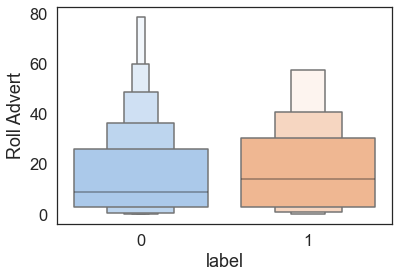

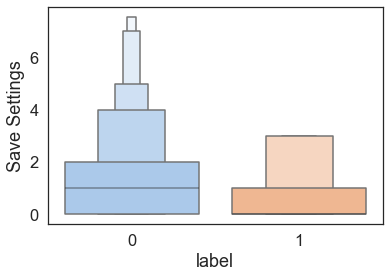

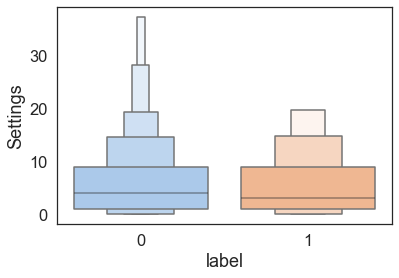

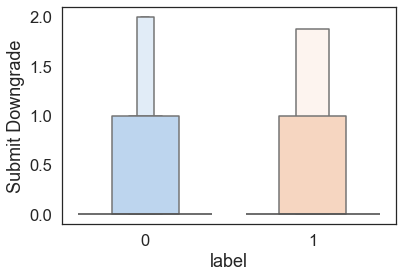

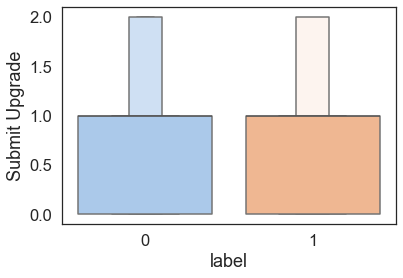

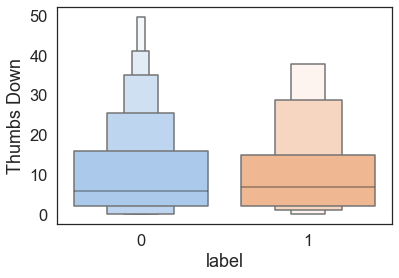

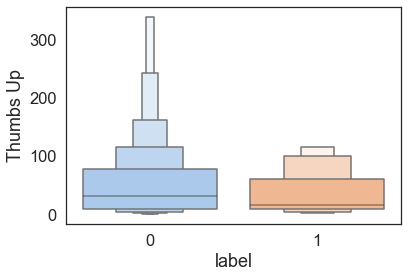

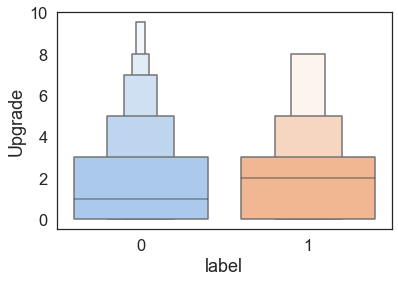

In [32]:
g = df.filter(~df['page'].isin(['Cancellation Confirmation','Cancel']))\
    .groupBy('label','userId')\
    .pivot('page')\
    .count()\
    .fillna(0)\
    .toPandas()

cols_list = [col for col in g.columns if col not in ['label','userId']]
for col in cols_list:
    sns.boxenplot(data=g, x='label', y=col, showfliers=False)
    plt.show();

Median count of Upgrade, Thumbs Down, Roll Advert page of churned users are higher than nonchurned users

### What is the difference of distribution in registraton date between users of two groups?

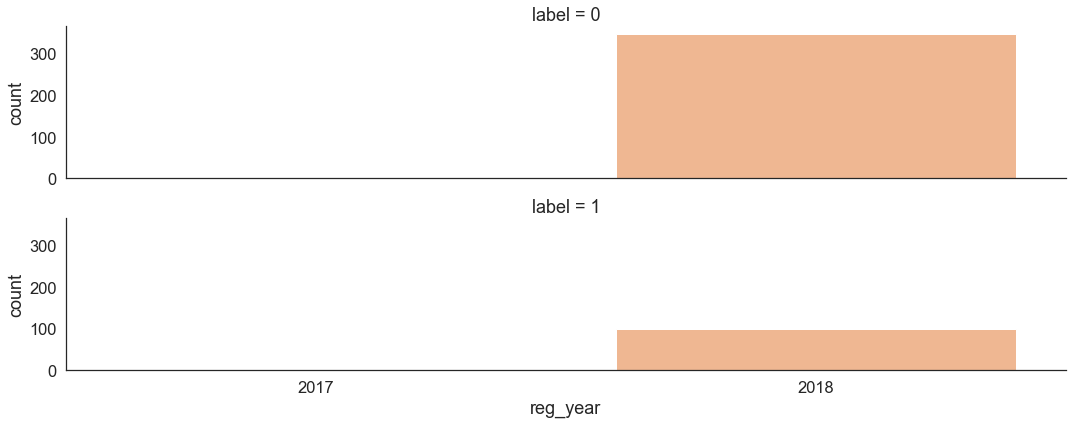

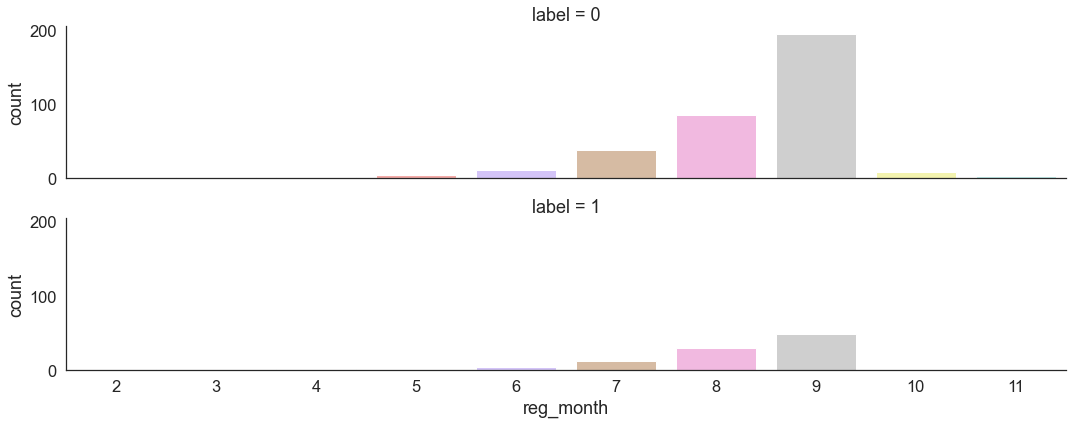

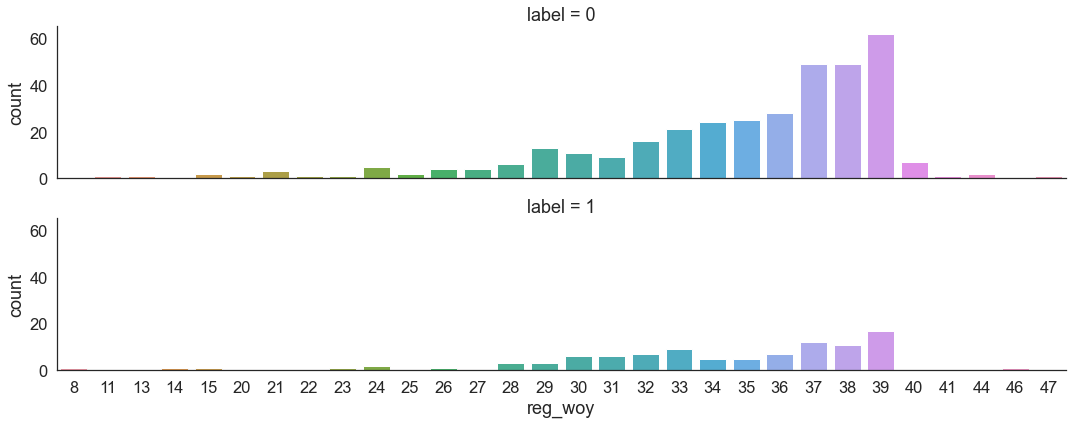

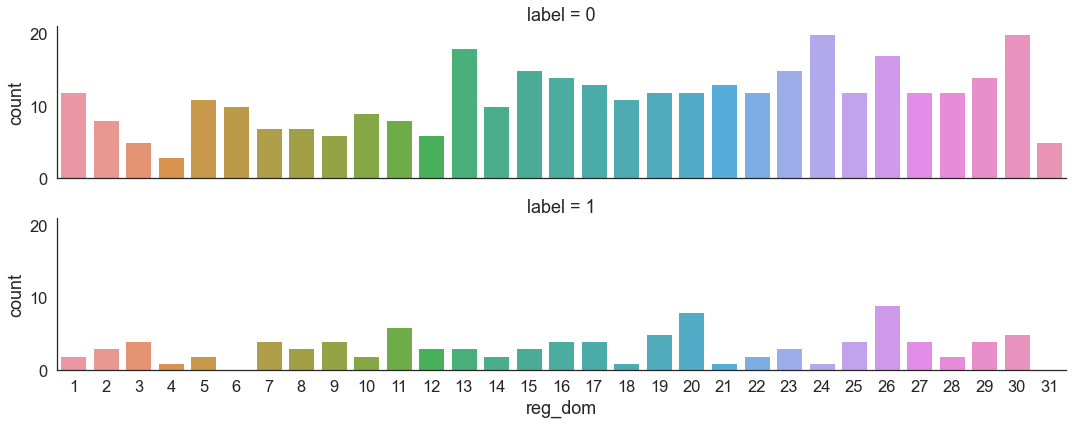

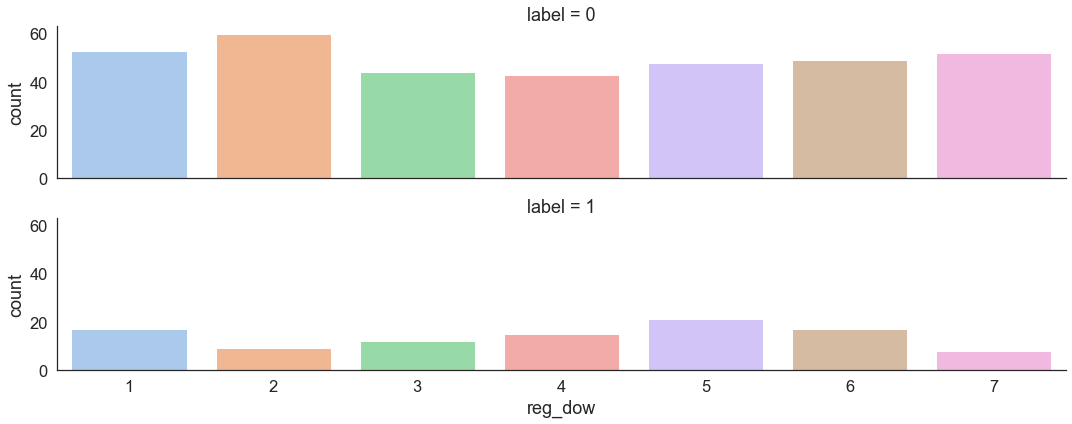

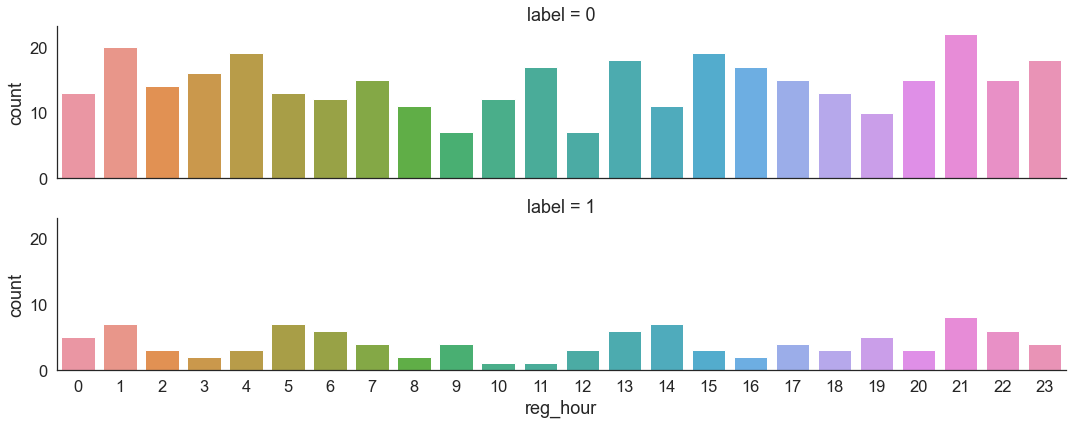

In [33]:
reg_list = [col for col in df.columns if col.startswith('reg_') and not col.endswith('datetime')]
df_ = df.select(['label','userId']+reg_list).dropDuplicates().toPandas()
for col in reg_list:
    print('\n\n')
    sns.catplot(data=df_, row='label', x=col, kind='count', height=3, aspect=5)
    plt.show();

### What are the differences in lifetime between users of two groups?

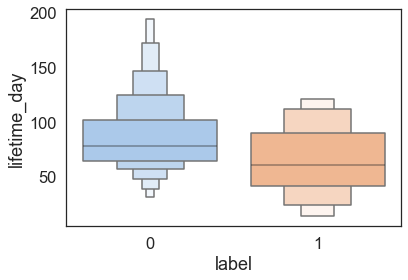

In [34]:
# days since registration
g = df.groupBy('label', 'userId').agg(
    F.max('ts').alias('max_dt'),
    F.min('registration').alias('reg_dt')
).withColumn('lifetime_day', (F.col('max_dt') - F.col('reg_dt'))/1000/60/60/24).toPandas()

sns.boxenplot(data=g, y='lifetime_day', x='label', showfliers=False);

Lifetime of churned users is slightly shorter than nonchurned users.

### How many songs have users of two groups heard?

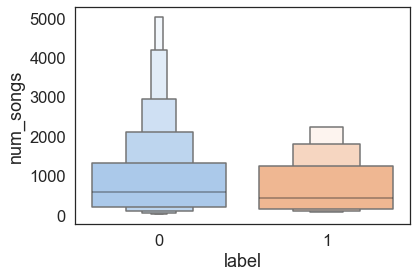

In [35]:
# number of songs
g = df.groupBy('label','userId').agg(F.count('song').alias('num_songs')).toPandas()

sns.boxenplot(data=g, x='label', y='num_songs', showfliers=False);

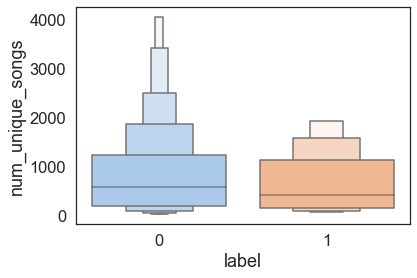

In [36]:
# number of unique songs
g = df.groupBy('label','userId').agg(F.count_distinct('song').alias('num_unique_songs')).toPandas()

sns.boxenplot(data=g, x='label', y='num_unique_songs', showfliers=False);

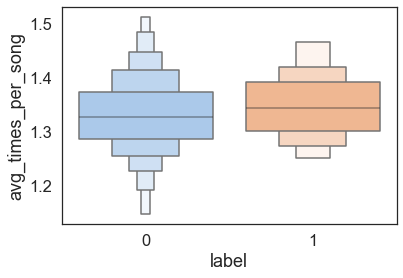

In [37]:
# average times per song
g = df.groupBy('label','userId','song').count()\
    .groupBy('label','userId').agg(F.avg('count').alias('avg_times_per_song'))\
    .toPandas()

sns.boxenplot(data=g, x='label', y='avg_times_per_song', showfliers=False);

Average times per song listened by churned users are slightly higher than nonchurned users

### When are users of two groups most active?

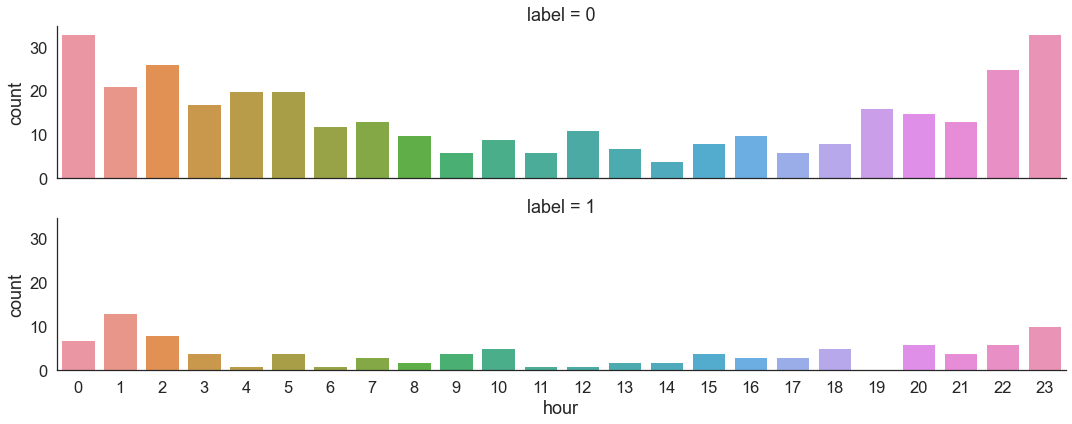

In [38]:
windowSpec  = Window.partitionBy("userId").orderBy(F.desc(F.col("num_pages")))

g = df.groupBy('label','userId','hour').agg(F.count('page').alias('num_pages'))\
    .withColumn("row_number",F.row_number().over(windowSpec))

g = g.filter(g['row_number']==1).toPandas()

sns.catplot(data=g, x='hour', kind='count', row='label', aspect=5, height=3);

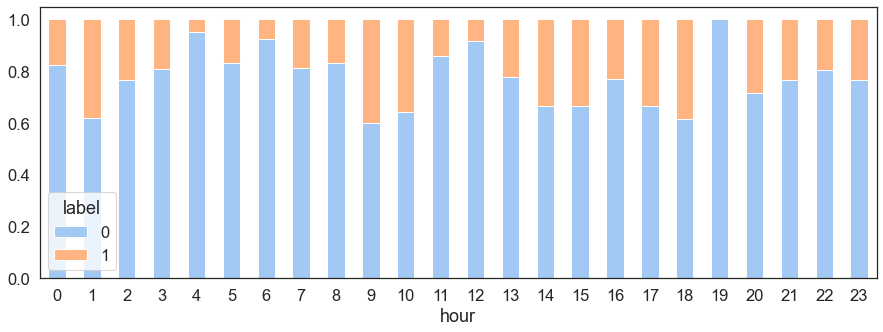

In [39]:
pd.crosstab(index=g['hour'], columns=g['label'], normalize="index").plot(kind='bar', stacked=True, figsize=(15,5))
plt.xticks(rotation=0);

Users most active at 1AM and 9AM are more likely to churn.

### When are users most likely to churn?

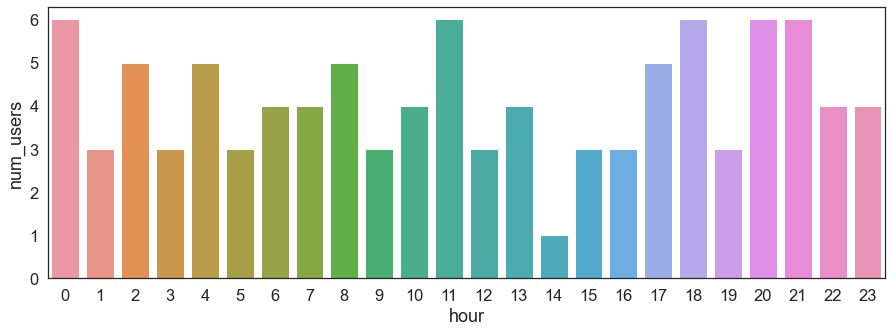

In [40]:
g = df.filter(df['page']=='Cancellation Confirmation')\
    .groupBy('hour').agg(F.count_distinct('userId').alias('num_users'))\
    .orderBy('hour')\
    .toPandas()

plt.figure(figsize=(15,5))
sns.barplot(data=g, x='hour', y='num_users');

Users are more likely to churn at 0AM, 11AM, 18AM, 20AM, and 21AM

### What is the difference of devices used by users of two groups?

In [41]:
df.select('userAgent').dropDuplicates().show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


In [42]:
device_func = F.udf(lambda x: x.split('(')[1].replace(';',' ').split(' ')[0])
g = df.withColumn('device', device_func('userAgent'))\
    .groupBy('label','device').agg(F.count_distinct('userId').alias('num_users'))\
    .orderBy('label')\
    .toPandas()

g

,label,device,num_users
0,0,compatible,11
1,0,iPad,9
2,0,iPhone,7
3,0,X11,21
4,0,Windows,163
5,0,Macintosh,138
6,1,Macintosh,35
7,1,iPhone,11
8,1,compatible,2
9,1,X11,5


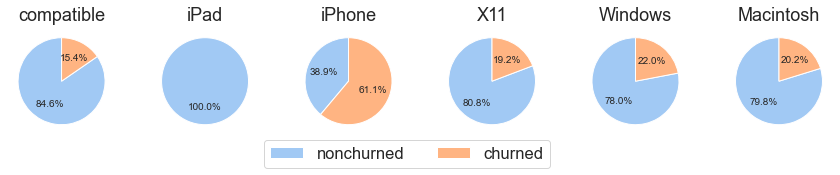

In [43]:
labels = ['nonchurned','churned']

fig, ax = plt.subplots(ncols=g['device'].nunique(), figsize=(15,2))
for i, device in enumerate(g['device'].unique()):
    ax[i].set_title(device)
    ax[i].pie(g[g.device==device]['num_users'],startangle=90,autopct='%1.1f%%')

fig.legend(labels, loc='center', bbox_to_anchor=(0.5,-0.001), ncol=len(labels), bbox_transform=fig.transFigure)
plt.show()

iPhone users are most likely to churn, while iPad users are least likely to churn.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [44]:
# number of artists
g_artist = df.groupBy('label', 'userId').agg(F.count_distinct('artist').alias('artists_cnt'))

# length of songs
g_length = df.groupBy('label', 'userId').agg(
	F.sum('length').alias('sum_length'),
	F.avg('length').alias('mean_length'),
    F.max('length').alias('max_length'),
    F.min('length').alias('min_length'),
    F.expr('percentile_approx(length, 0.5)').alias('median_length')
)

# gender
d_gender = df.select('label', 'userId', 'gender').dropDuplicates()

# level
level_func = F.udf(lambda x: int(x=='paid'), T.IntegerType())
d_level = df.withColumn('is_paid', level_func('level'))\
    .groupBy('label','userId').agg(F.max('is_paid').alias('is_paid'))

# location
state_func = F.udf(lambda x: x[-2:])
d_state = df.withColumn('state', state_func('location'))\
    .select('label','userId','state')\
    .dropDuplicates()

# page
g_page = df.filter(~df['page'].isin(['Cancellation Confirmation','Cancel']))\
    .groupBy('label','userId')\
    .pivot('page')\
    .count()\
    .fillna(0)

page_list = df.select('page').rdd.flatMap(lambda x: x).collect()
page_list = list(set(page_list).difference(set(['Cancellation Confirmation', 'Cancel'])))

for page in page_list:
    g_page = g_page.withColumnRenamed(page, f"{page.lower().replace(' ', '')}_pagecnt")

# days since registration
g_lifetime = df.groupBy('label', 'userId').agg(
    F.max('ts').alias('max_dt'),
    F.min('registration').alias('reg_dt')
).withColumn('lifetime_day', (F.col('max_dt') - F.col('reg_dt'))/1000/60/60/24)\
.select('label','userId','lifetime_day')

# number of songs
g_songs = df.groupBy('label','userId').agg(
	F.count('song').alias('songs_cnt'),
	F.count_distinct('song').alias('unique_songs_cnt')
)

# average times per song
g_song_times = df.groupBy('label','userId','song').count()\
    .groupBy('label','userId')\
    .agg(F.avg('count').alias('avg_times_per_song'))

# pct of pages a users hit each hour
g_hour = df.groupBy('label','userId','hour').agg(F.count('page').alias('num_pages'))\
    .groupBy('label','userId').pivot('hour').sum('num_pages').fillna(0)\

g_page_ = df.groupBy('label','userId').agg(F.count('page'))
g_hour = g_hour.join(g_page_, on=['label','userId'])

for i in range(24):
    g_hour = g_hour.withColumn(str(i), (F.col(str(i))/F.col('count(page)')))\
    	.withColumnRenamed(str(i), f'pages_cnt_hr{i}')

g_hour = g_hour.drop('count(page)')

# device
device_func = F.udf(lambda x: x.split('(')[1].replace(';',' ').split(' ')[0])
g_device = df.withColumn('device', device_func('userAgent'))\
		.select('label','userId','device')\
        .dropDuplicates()

# join all features
df_features = g_artist.join(g_length, on=['label','userId'])\
		.join(d_gender, on=['label','userId'])\
		.join(d_level, on=['label','userId'])\
		.join(d_state, on=['label','userId'])\
		.join(g_page, on=['label','userId'])\
		.join(g_lifetime, on=['label','userId'])\
		.join(g_songs, on=['label','userId'])\
		.join(g_song_times, on=['label','userId'])\
		.join(g_hour, on=['label','userId'])\
		.join(g_device, on=['label','userId'])

In [45]:
df_features.columns

['label',
 'userId',
 'artists_cnt',
 'sum_length',
 'mean_length',
 'max_length',
 'min_length',
 'median_length',
 'gender',
 'is_paid',
 'state',
 'about_pagecnt',
 'addfriend_pagecnt',
 'addtoplaylist_pagecnt',
 'downgrade_pagecnt',
 'error_pagecnt',
 'help_pagecnt',
 'home_pagecnt',
 'logout_pagecnt',
 'nextsong_pagecnt',
 'rolladvert_pagecnt',
 'savesettings_pagecnt',
 'settings_pagecnt',
 'submitdowngrade_pagecnt',
 'submitupgrade_pagecnt',
 'thumbsdown_pagecnt',
 'thumbsup_pagecnt',
 'upgrade_pagecnt',
 'lifetime_day',
 'songs_cnt',
 'unique_songs_cnt',
 'avg_times_per_song',
 'pages_cnt_hr0',
 'pages_cnt_hr1',
 'pages_cnt_hr2',
 'pages_cnt_hr3',
 'pages_cnt_hr4',
 'pages_cnt_hr5',
 'pages_cnt_hr6',
 'pages_cnt_hr7',
 'pages_cnt_hr8',
 'pages_cnt_hr9',
 'pages_cnt_hr10',
 'pages_cnt_hr11',
 'pages_cnt_hr12',
 'pages_cnt_hr13',
 'pages_cnt_hr14',
 'pages_cnt_hr15',
 'pages_cnt_hr16',
 'pages_cnt_hr17',
 'pages_cnt_hr18',
 'pages_cnt_hr19',
 'pages_cnt_hr20',
 'pages_cnt_hr21',
 

In [46]:
df_features.show(1)

22/08/03 20:48:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+------+-----------+-----------------+---------------+----------+----------+-------------+------+-------+-----+-------------+-----------------+---------------------+-----------------+-------------+------------+------------+--------------+----------------+------------------+--------------------+----------------+-----------------------+---------------------+------------------+----------------+---------------+-----------------+---------+----------------+------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------+
|label|userId|artists_cn

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [47]:
df_features.count()

448

In [48]:
df_features.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



In [49]:
df_features.printSchema()

root
 |-- label: integer (nullable = false)
 |-- userId: string (nullable = true)
 |-- artists_cnt: long (nullable = false)
 |-- sum_length: double (nullable = true)
 |-- mean_length: double (nullable = true)
 |-- max_length: double (nullable = true)
 |-- min_length: double (nullable = true)
 |-- median_length: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- is_paid: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- about_pagecnt: long (nullable = true)
 |-- addfriend_pagecnt: long (nullable = true)
 |-- addtoplaylist_pagecnt: long (nullable = true)
 |-- downgrade_pagecnt: long (nullable = true)
 |-- error_pagecnt: long (nullable = true)
 |-- help_pagecnt: long (nullable = true)
 |-- home_pagecnt: long (nullable = true)
 |-- logout_pagecnt: long (nullable = true)
 |-- nextsong_pagecnt: long (nullable = true)
 |-- rolladvert_pagecnt: long (nullable = true)
 |-- savesettings_pagecnt: long (nullable = true)
 |-- settings_pagecnt: long (nullable = true

In [50]:
# pipeline
str_cols = ['gender','state','device']
str_indexer = M.feature.StringIndexer(
    inputCols=str_cols,
    outputCols=[f'{col}_idx' for col in str_cols]
)

assembler_cols = df_features.columns
assembler_cols = list(set(assembler_cols).difference(set(str_cols)).difference(set(['label','userId']))) + [f'{col}_idx' for col in str_cols]
assembler = M.feature.VectorAssembler(inputCols=assembler_cols, outputCol='features')

features_pipeline = M.Pipeline(stages=[
    str_indexer,
    assembler
])

df_model = features_pipeline.fit(df_features).transform(df_features)

In [51]:
# train test split
train, test = df_model.randomSplit([.8,.2], seed=2022)

In [52]:
clf = M.classification.LogisticRegression()
model = clf.fit(train)
results = model.transform(test)

acc_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

f1_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

print(f'Logistic Regression\n\taccuracy on test set: {accuracy}\n\tf1 score on test set: {f1_score}')

22/08/03 20:51:49 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/08/03 20:51:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/03 20:51:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Logistic Regression
	accuracy on test set: 0.7386363636363636
	f1 score on test set: 0.7189877498388136


In [53]:
clf = M.classification.LinearSVC()
model = clf.fit(train)
results = model.transform(test)

acc_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

f1_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

print(f'Support Vector Machine\n\taccuracy on test set: {accuracy}\n\tf1 score on test set: {f1_score}')

Support Vector Machine
	accuracy on test set: 0.7840909090909091
	f1 score on test set: 0.7614431023521933


In [54]:
clf = M.classification.DecisionTreeClassifier(maxBins=60)
model = clf.fit(train)
results = model.transform(test)

acc_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

f1_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

print(f'Decision Tree\n\taccuracy on test set: {accuracy}\n\tf1 score on test set: {f1_score}')

Decision Tree
	accuracy on test set: 0.6477272727272727
	f1 score on test set: 0.6631813068820943


In [55]:
clf = M.classification.RandomForestClassifier(maxBins=60)
model = clf.fit(train)
results = model.transform(test)

acc_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

f1_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

print(f'Random Forest\n\taccuracy on test set: {accuracy}\n\tf1 score on test set: {f1_score}')

Random Forest
	accuracy on test set: 0.7727272727272727
	f1 score on test set: 0.7009569377990431


In [56]:
clf = M.classification.GBTClassifier(maxBins=60)
model = clf.fit(train)
results = model.transform(test)

acc_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

f1_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

print(f'Gradient Boosting\n\taccuracy on test set: {accuracy}\n\tf1 score on test set: {f1_score}')

Gradient Boosting
	accuracy on test set: 0.7159090909090909
	f1 score on test set: 0.7181444626365067


### Since f1 score of SVC is highest, I will tune hyperparameters on SVC

In [57]:
clf = M.classification.LinearSVC()
param_grid = M.tuning.ParamGridBuilder()\
    .addGrid(clf.maxIter, [50, 100])\
    .addGrid(clf.regParam, [0.01,0.05])\
    .build()

crossval = M.tuning.CrossValidator(
    estimator=M.Pipeline(stages=[clf]),
    estimatorParamMaps=param_grid,
    evaluator=M.evaluation.MulticlassClassificationEvaluator(metricName='f1'),
    numFolds=3
)

model = crossval.fit(train)
results = model.transform(test)

# accuracy
acc_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

# f1 score
f1_evaluator = M.evaluation.MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_evaluator.evaluate(results.select(F.col('label'), F.col('prediction')))

print(f'Support Vector Machine\n\taccuracy on test set: {accuracy}\n\tf1 score on test set: {f1_score}')

0]

Support Vector Machine
	accuracy on test set: 0.8181818181818182
	f1 score on test set: 0.7813267813267813


### Parameters

In [66]:
best_mod = model.bestModel
param_dict = best_mod.stages[-1].extractParamMap()

sane_dict = {}
for k, v in param_dict.items():
  sane_dict[k.name] = v

best_reg = sane_dict["regParam"]
best_max_iter = sane_dict["maxIter"]

print(f'Best reg: {best_reg}, best max_iter: {best_max_iter}')

Best reg: 0.01, best max_iter: 50


In [67]:
bestCLModel = best_mod.stages[-1]
feature_coef = bestCLModel.coefficients.values.tolist()

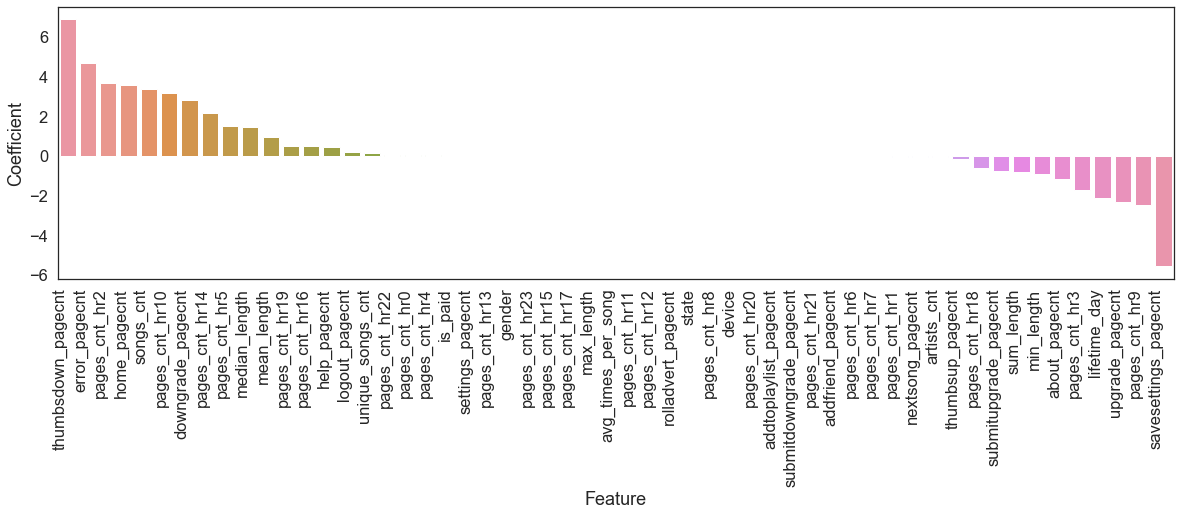

In [70]:
# feature importance
feature_cols = df_features.drop('label').drop('userId').columns
bestCLModel = best_mod.stages[-1]
feature_coef = bestCLModel.coefficients.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature','Coefficient']).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(data=feature_coef_df, x='Feature', y='Coefficient')
#plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=90, ha='right');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.